In [1]:
%matplotlib inline

In [2]:
import sys

import IPython.display as ipd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
import os

from torchaudio.datasets import SPEECHCOMMANDS


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__(root="./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

In [6]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
# labels

In [7]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [11]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.0)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [26]:
import matplotlib.pyplot as plt
import torch
from bindsnet.analysis.plotting import plot_spikes, plot_voltages
from bindsnet.network import Network
from bindsnet.network.monitors import Monitor
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.topology import Connection
from bindsnet.learning import PostPre

# Simulation time.
time = 500

# Create the network.
network = Network()

# Create and add input, output layers.
# source_layer = Input(n=100,traces=True)
source_layer = Input(n=100)
target_layer = LIFNodes(n=1000)

network.add_layer(layer=source_layer, name="A")
network.add_layer(layer=target_layer, name="B")

# Create connection between input and output layers.
forward_connection = Connection(
    source=source_layer,
    target=target_layer,
    w=0.05 + 0.1 * torch.randn(source_layer.n, target_layer.n),  # Normal(0.05, 0.01) weights.
    # update_rule=PostPre,
    # nu=(1e-4, 1e-2),
)

network.add_connection(connection=forward_connection, source="A", target="B")

# Create recurrent connection in output layer.
recurrent_connection = Connection(
    source=target_layer,
    target=target_layer,
    w=0.025 * (torch.eye(target_layer.n) - 1),  # Small, inhibitory "competitive" weights.
    # update_rule=PostPre,
    # nu=(1e-4, 1e-2),
)

network.add_connection(connection=recurrent_connection, source="B", target="B")

# Create and add input and output layer monitors.
source_monitor = Monitor(
    obj=source_layer,
    state_vars=("s",),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)
target_monitor = Monitor(
    obj=target_layer,
    state_vars=("s", "v"),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)

network.add_monitor(monitor=source_monitor, name="A")
network.add_monitor(monitor=target_monitor, name="B")

In [27]:
# Create input spike data, where each spike is distributed according to Bernoulli(0.1).
input_data = torch.bernoulli(0.1 * torch.ones(time, source_layer.n)).byte()
inputs = {"A": input_data}

# print(type(input_data))
# inputs={"A":train_loader}

# Simulate network on input data.
network.run(inputs=inputs, time=time)

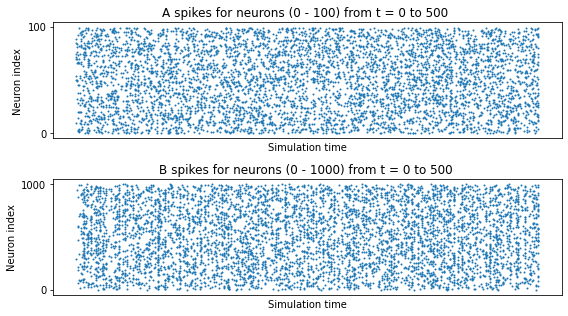

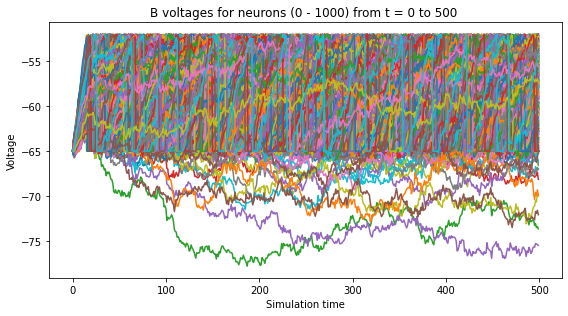

In [28]:
# Retrieve and plot simulation spike, voltage data from monitors.
spikes = {"A": source_monitor.get("s"), "B": target_monitor.get("s")}
voltages = {"B": target_monitor.get("v")}

plt.ioff()
plot_spikes(spikes)
plot_voltages(voltages, plot_type="line")
plt.show()